In [1]:
import torch
import torchvision

from models import LFADS
from utils import read_data, load_parameters, save_parameters, batchify_random_sample

np = torch._np
import matplotlib.pyplot as plt
import yaml
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


In [3]:
author = 'lyprince'
seed = 100
if os.path.exists('./synth_data/lorenz_%s'%seed):
    data_dict = read_data('./synth_data/lorenz_%s'%seed)
else:
    from synthetic_data import generate_lorenz_data
    data_dict = generate_lorenz_data(N_cells=30, N_inits=65, N_trials=20, N_steps=200, N_stepsinbin=2, dt_lorenz=0.015, dt_spike = 1./20, base_firing_rate= 1.0, save=True)

# For spike data
train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = {'rates'  : data_dict['train_rates'],
               'latent' : data_dict['train_latent']}

valid_truth = {'rates'  : data_dict['valid_rates'],
               'latent' : data_dict['valid_latent']}

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape;
print(train_data.shape);
print('Number of datapoints = %s'%train_data.numel())

/network/home/princelu/pytorch/lib/python3.7/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


Saving variable with name:  train_latent
Saving variable with name:  valid_latent
Saving variable with name:  train_rates
Saving variable with name:  valid_rates
Saving variable with name:  train_spikes
Saving variable with name:  valid_spikes
Saving variable with name:  train_calcium
Saving variable with name:  valid_calcium
Saving variable with name:  train_fluor
Saving variable with name:  valid_fluor
Saving variable with name:  train_oasis
Saving variable with name:  valid_oasis
Saving variable with name:  train_data
Saving variable with name:  valid_data
Saving variable with name:  train_truth
Saving variable with name:  valid_truth
Saving variable with name:  dt
Saving variable with name:  loading_weights
Saving variable with name:  conversion_factor
torch.Size([1040, 100, 30])
Number of datapoints = 3120000


In [4]:
hyperparams = load_parameters('./parameters/parameters_lorenz_spikes.yaml')
hyperparams['run_name'] += '_demo'
save_parameters(hyperparams, path=None)

hyperparams

/network/home/princelu/hierarchical_lfads/utils.py:91: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(path))


{'betas': (0.9, 0.99),
 'clip_val': 5.0,
 'dataset_name': 'lorenz',
 'datatype': 'spikes',
 'epsilon': 0.1,
 'factors_dim': 3,
 'g0_encoder_dim': 64,
 'g0_prior_kappa': 0.1,
 'g0_prior_var_max': 0.1,
 'g0_prior_var_min': 0.1,
 'g_dim': 64,
 'keep_prob': 0.95,
 'kernel_dim': 20,
 'kl_weight_min': 0.0,
 'kl_weight_schedule_dur': 1600,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 250,
 'l2_weight_min': 0.0,
 'l2_weight_schedule_dur': 1600,
 'l2_weight_schedule_start': 0.0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'norm_factors': True,
 'run_name': 'poisson_demo',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 0,
 'u_prior_kappa': 0.1,
 'use_weight_schedule_fn': True}

In [5]:
model = LFADS(inputs_dim = num_cells, T = num_steps, dt = float(data_dict['dt']), device=device,
              model_hyperparams=hyperparams).to(device)

Random seed: 8085


In [6]:
model.load_checkpoint('recent')

In [7]:
model.fit(train_ds, valid_ds, train_truth=train_truth, valid_truth=valid_truth,
          max_epochs=2000, batch_size=65, use_tensorboard=False, health_check=False)

Beginning training...
Epoch:    1, Step:    16, training loss: 1357.967, validation loss: 1508.676
Epoch:    2, Step:    32, training loss: 1336.111, validation loss: 1380.983
Epoch:    3, Step:    48, training loss: 1322.964, validation loss: 1357.874
Epoch:    4, Step:    64, training loss: 1314.050, validation loss: 1354.084
Epoch:    5, Step:    80, training loss: 1303.039, validation loss: 1361.482
Epoch:    6, Step:    96, training loss: 1294.331, validation loss: 1354.538
Epoch:    7, Step:   112, training loss: 1291.596, validation loss: 1359.911
Epoch:    8, Step:   128, training loss: 1290.228, validation loss: 1345.400
Epoch:    9, Step:   144, training loss: 1279.535, validation loss: 1336.581
Epoch:   10, Step:   160, training loss: 1276.780, validation loss: 1346.782
Epoch:   11, Step:   176, training loss: 1274.423, validation loss: 1335.389
Epoch:   12, Step:   192, training loss: 1268.930, validation loss: 1317.434
Epoch:   13, Step:   208, training loss: 1268.774, val

In [8]:
model.load_checkpoint('best')

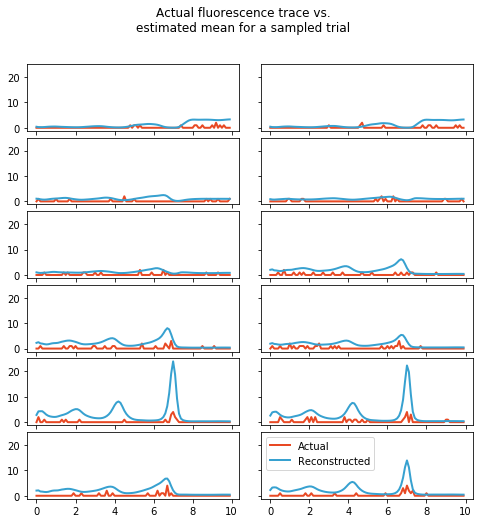

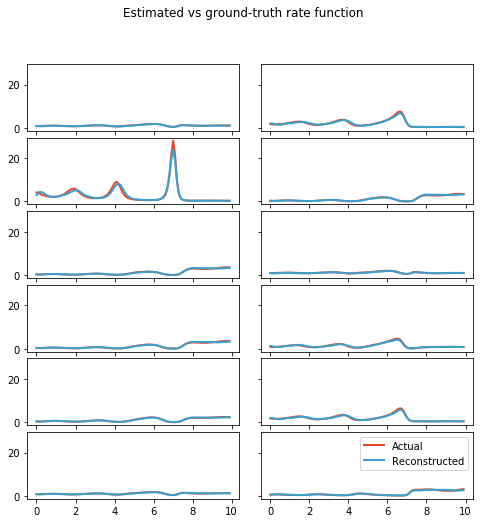

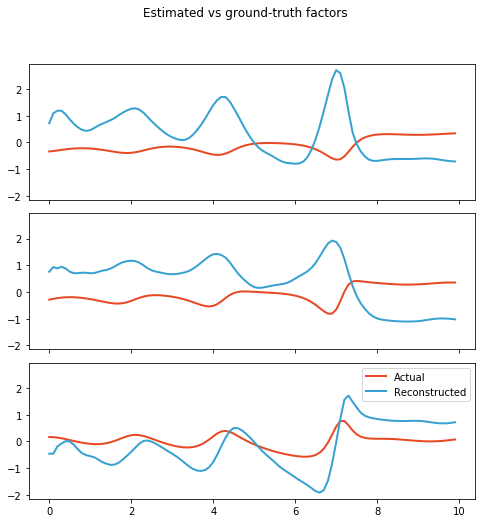

In [9]:
fig_dict = model.plot_summary(data=valid_data, truth=valid_truth)

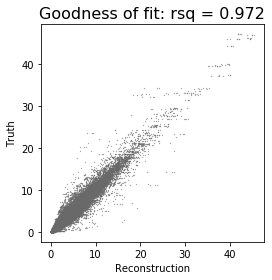

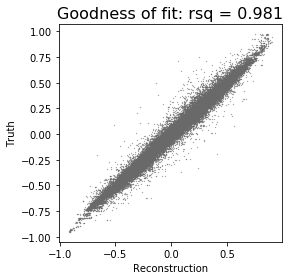

In [10]:
results_dict = model.plot_recon_rsquared(valid_data, valid_truth, train_data, train_truth)

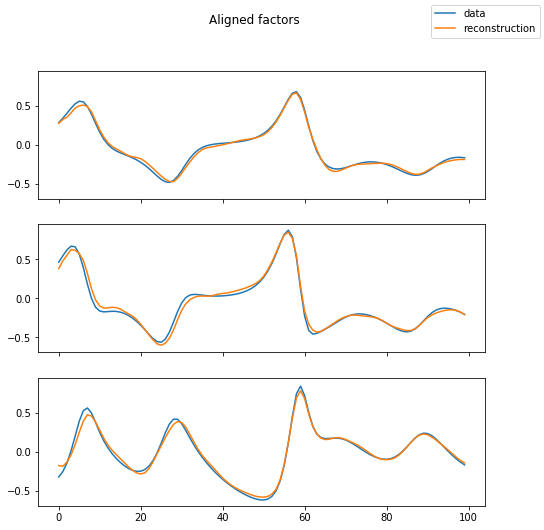

In [11]:
fig, axs = plt.subplots(figsize=(8,8), nrows=3, ncols=1, sharex=True, sharey=True)
for ix in range(3):
    plt.sca(axs[ix])
    plt.plot(data_dict['valid_latent'][0, :100, ix])
    plt.plot(results_dict['factors']['aligned'][:100, ix])
    
fig.suptitle('Aligned factors')
fig.legend(['data', 'reconstruction'])